In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from art.utils import load_mnist, preprocess

import os
import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

c:\Users\loren\anaconda3\envs\fed-learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN=False
COMPUTE_HESSIAN=False
save_path = 'models/model.pt'
load_path = 'models/model.pt'

#### FL Fusion Class Selection

In [3]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [4]:
num_parties = 5
scale = 1
#Select the party that I would like to erase (ex: 3)
party_to_be_erased = 2

num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data
<a id='section_2'></a>

In [5]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Create Trainloader

In this Notebook we are going to create it by the following principle:
 - Each client will have 50% of it's dataset given by classes common among all the clients
 - Remaining 50% will be given to each client and will be different among different clients

Example:
client 3 will have 50% given by the labels: [0,1,2,3,4]. 50% will be with data coming just from the label [7]

In [6]:
all_indices = np.arange(len(y_train))
common_classes_indices = all_indices[np.sum(y_train*np.array([1,1,1,1,1,0,0,0,0,0]), axis = 1).astype(bool)]
list_clients_dataset_indices = np.split(common_classes_indices[:-(len(common_classes_indices)%5)], 5)

for i in range(5,10):
  label = [0,0,0,0,0,0,0,0,0,0]
  label[i] = 1
  indx = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
  list_clients_dataset_indices[i-5] = np.concatenate((list_clients_dataset_indices[i-5], indx[:len(indx)//5]))

x_train_ch = np.expand_dims(x_train, axis=1)
y_train_c = np.argmax(y_train, axis=1).astype(int)
trainloader_lst = []
for indices in list_clients_dataset_indices:
  ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
  trainloader_lst.append(DataLoader(ds, batch_size=128, shuffle=True))

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

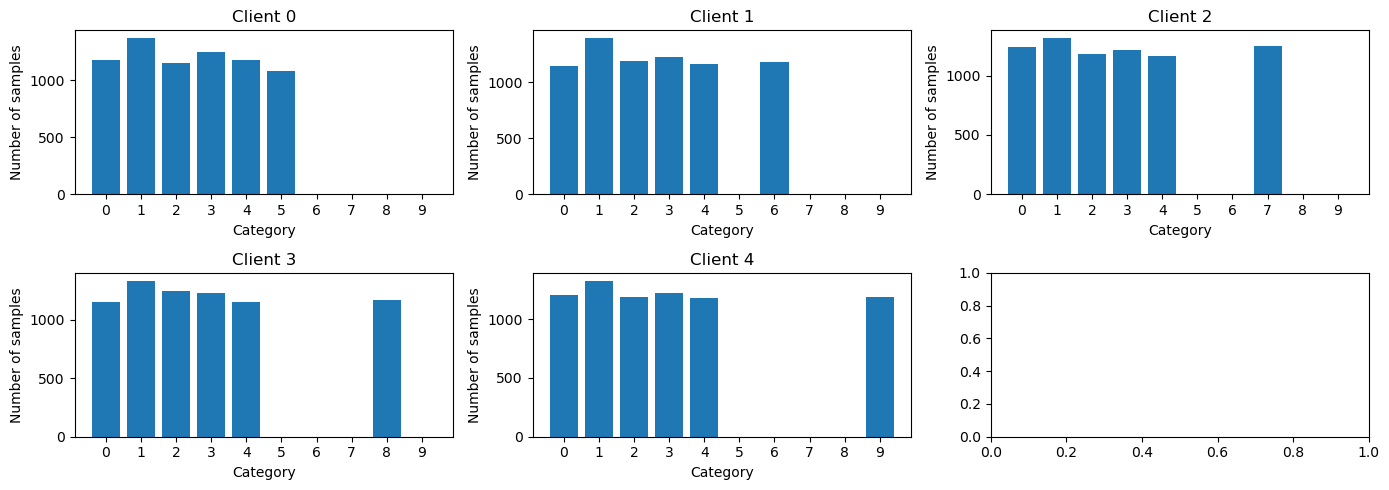

In [7]:
client_stats=[[]for i in range(5)]
for client in range(5):
    for category in range(10):
        client_indices=list_clients_dataset_indices[client]
        count=0
        for i in client_indices:
            if y_train_c[i]==category:
                count+=1
        client_stats[client].append(count)

axs = fig, axs = plt.subplots(2, 3, figsize=(14, 5))
for i,client in enumerate(client_stats):
    axs[i//3][i%3].bar(range(10),client)
    axs[i//3][i%3].set_title('Client '+str(i))
    axs[i//3][i%3].set_xticks(range(10))
    axs[i//3][i%3].set_xticklabels(range(10))
    axs[i//3][i%3].set_xlabel('Category')
    axs[i//3][i%3].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()


## 2. Train the FL Model
<a id='section_3'></a>

In [8]:
num_of_repeats = 1
num_fl_rounds = 50

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [9]:
class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [10]:
if TRAIN:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.cuda.empty_cache()
    party_models_dict = {}
    initial_model = FLNet2()
    model_dict = {}

    for fusion_key in fusion_types:
        model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

    for round_num in range(num_fl_rounds):
        local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

        for fusion_key in fusion_types:
            fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

            current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
            model = copy.deepcopy(initial_model)
            model.load_state_dict(current_model_state_dict)

            ##################### Local Training Round #############################
            party_models = []
            party_losses = []
            party_grad   = []        
            for party_id in range(num_parties):

                if fusion_key == 'Retrain':
                    break
                else:
                    model = copy.deepcopy(model).to(device)
                    model_update, party_loss = local_training.train(model=model,
                                                trainloader=trainloader_lst[party_id],
                                                device = device,
                                                criterion=None, opt=None)

                    party_models.append(copy.deepcopy(model_update.to('cpu')))
                    party_losses.append(party_loss)

                grad_norm = 0.0
                for param in model_update.parameters():
                    if param.grad is not None:
                        grad_norm += torch.norm(param.grad).cpu().item()
            
                party_grad.append(grad_norm)   
            
            grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

            loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
            ######################################################################

            current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

            model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
            party_models_dict[fusion_key] = party_models

            eval_model = FLNet2()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = Utils.evaluate(testloader, eval_model)
            clean_accuracy[fusion_key][round_num] = clean_acc
            print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

In [11]:
if TRAIN:
    def save_model_with_unique_name(model, base_path):
        # Split the base_path into the file name and extension
        base, ext = os.path.splitext(base_path)
        new_path = base_path
        counter = 1
        
        # Check if the file exists and update the filename if needed
        while os.path.exists(new_path):
            new_path = f"{base}({counter}){ext}"
            counter += 1

        torch.save(model.state_dict(), new_path)
        print(f"Model saved to {new_path}")

    eval_model = FLNet2()
    eval_model.load_state_dict(current_model_state_dict)
    save_model_with_unique_name(eval_model, save_path)

In [12]:
saved_model = FLNet2()
saved_model.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

In [13]:
def create_dataloader(idx_client, _list_trainloader, percentage_to_remove):
    list_trainloader = copy.deepcopy(_list_trainloader)
    client_dataset = list_trainloader[idx_client].dataset

    num_samples_to_remove = int(len(client_dataset) * percentage_to_remove)
    num_samples_to_keep = len(client_dataset) - num_samples_to_remove
    
    if num_samples_to_keep != 0:
        new_dataset = TensorDataset(client_dataset[:num_samples_to_keep][0], client_dataset[:num_samples_to_keep][1])
        list_trainloader[idx_client] = DataLoader(new_dataset, batch_size=128)

    else:
        list_trainloader.pop(idx_client)

    return list_trainloader, num_samples_to_remove

In [14]:
from torch.utils.data import ConcatDataset

def analyze_removal(_model, _trainloader_list):
    remove_percentages = np.linspace(0, 1, 10)
    trainloader_list = copy.deepcopy(_trainloader_list)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = copy.deepcopy(_model).to(device)
    criterion = nn.CrossEntropyLoss()


    # Shuffle training datasets for each client only at the beginning
    # (this is done to avoid fictitious determinism in the results)
    training_datasets = [loader.dataset for loader in trainloader_list]
    shuffled_training_datasets = []
    for dataset in training_datasets:
        indices = np.random.permutation(len(dataset))
        shuffled_training_datasets.append(TensorDataset(dataset[indices][0], dataset[indices][1]))
    shuffled_trainloader_list = [DataLoader(dataset, batch_size=128) for dataset in shuffled_training_datasets]

    results = []

    for remove_percentage in remove_percentages:

        trainloader_list, _ = create_dataloader(party_to_be_erased, shuffled_trainloader_list, remove_percentage)
        
        client_dataset = ConcatDataset([loader.dataset for loader in trainloader_list])
        loader = DataLoader(client_dataset, batch_size=128)

        loss_sum = 0
        grad_sum = torch.zeros_like(torch.cat([param.flatten() for param in model.parameters()]))
        number_of_batches = 0

        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Sum quantities
            loss_sum += loss.cpu().item()
            grad_sum += torch.cat([param.grad.flatten() for param in model.parameters()])
            number_of_batches += 1
            
        grad_norm = torch.norm(grad_sum).cpu().item() / number_of_batches
        loss = loss_sum / number_of_batches

        
        # Store results
        results.append({
            'removal_percentage': remove_percentage,
            'gradient_norm': grad_norm,
            'loss': loss
        })
        
        print(f"Removal percentage: {remove_percentage:.2f}")
        print(f"  - Number of samples: {sum([len(loader.dataset) for loader in trainloader_list])}")
        print(f"  - Gradient norm: {grad_norm:.4f}")
        print(f"  - Loss: {loss:.4f}")
        print("-" * 50)

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Create plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot gradient norm vs Removal percentage
    axs[0].plot(results_df['removal_percentage'], results_df['gradient_norm'], 'o-')
    axs[0].set_title('Gradient Norm vs. Removal Percentage')
    axs[0].set_xlabel('Removal Percentage')
    axs[0].set_ylabel('Gradient Norm')
    axs[0].grid(True)

    # Plot loss vs Removal percentage
    axs[1].plot(results_df['removal_percentage'], results_df['loss'], 'o-')
    axs[1].set_title('Loss vs. Removal Percentage')
    axs[1].set_xlabel('Removal Percentage')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

#analyze_removal(saved_model, trainloader_lst)

In [15]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian(dataloader_list, model, criterion, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Store Hessians and batch counts per client
    client_hessians = []
    total_batches = 0

    # Calculate diagonal Hessian for each client
    for loader_idx, loader in enumerate(dataloader_list):
        accumulated_diag_h = {}
        print(f"Calculating diagonal Hessian for client {loader_idx}")
        
        for batch_idx, (inputs, targets) in enumerate(loader):
            # Compute diagonal Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)
            
            # Accumulate values
            for name, value in diag_h.items():
                if name not in accumulated_diag_h:
                    accumulated_diag_h[name] = value
                else:
                    accumulated_diag_h[name] += value
            
            total_batches += 1
        
        # Store results for this client
        client_hessians.append(accumulated_diag_h)


    # Normalize client importance weights
    if weights is None:
        weights = [1.0] * len(dataloader_list)

    # Weighted average of client Hessians
    weighted_avg_hessian = {}
    for name in client_hessians[0].keys():
        weighted_avg_hessian[name] = sum(
            client_hessians[i][name] * weights[i] for i in range(len(client_hessians))
        ) / total_batches
    
    return weighted_avg_hessian

#Lista di hessiane accumulate per client OK
#lista di total batches per client       OK
#peso tutti i client per batch del client/batch totali e in più il client target viene moltiplicato per weight


In [16]:
trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

#Use the model if coming from the training or load if you have it downloaded
final_model = copy.deepcopy(saved_model)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

special_weight = 0.01

# Calculate equal weights for others
other_weight = 1

# Create weights list
weights = [other_weight] * len(trainloader_list)
weights[party_to_be_erased] = special_weight


Compute Hessians

In [17]:

if COMPUTE_HESSIAN:
    accumulated_diag_h = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion)
    accumulated_diag_h_removed = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights)


OUR METHOD

In [18]:
def compute_true_info(hessian, hessian_removed, num_removed):
    A_list = [torch.empty_like(p) for p in hessian.values()]
    B_list = [torch.empty_like(p) for p in hessian.values()]
    for i,k in enumerate(hessian.keys()): 
        print(k)

        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_removed[k]==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        ratio = hessian_removed[k]/hessian[k]
        A=1/2 * torch.log(ratio)/num_removed
        B=1/2 * (1-ratio)/num_removed

        A[degeneracies_indices]=0
        B[degeneracies_indices]=0

        assert torch.sum(torch.isnan(A))==0, f"NaN values in A: {torch.sum(torch.isnan(A))}"
        assert torch.sum(torch.isnan(B))==0, f"NaN values in B: {torch.sum(torch.isnan(B))}"
        assert torch.sum(torch.isinf(A))==0, f"Inf values in A: {torch.sum(torch.isinf(A))}"
        assert torch.sum(torch.isinf(B))==0, f"Inf values in B: {torch.sum(torch.isinf(B))}"

        A_list[i]=A
        B_list[i]=B

    C = sum([torch.sum(A_list[i]+B_list[i]).item() for i in range(len(A_list))])

    information_true=[(A_list[i]+B_list[i])*C + 2*torch.pow(B_list[i],2) for i in range(len(hessian.keys()))]

    return information_true

In [19]:
if COMPUTE_HESSIAN:  
    info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor(special_weight))

In [20]:
if COMPUTE_HESSIAN:
    import pickle

    with open('cached/info_true.pkl', 'wb') as f:
        pickle.dump(info_true, f)

Load hessians

In [21]:
import pickle
with open('cached/info_true.pkl', 'rb') as f:
    info_true = pickle.load(f)

In [22]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

# 2. Plot the summed information
def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

1502687
Number of outliers: 30054


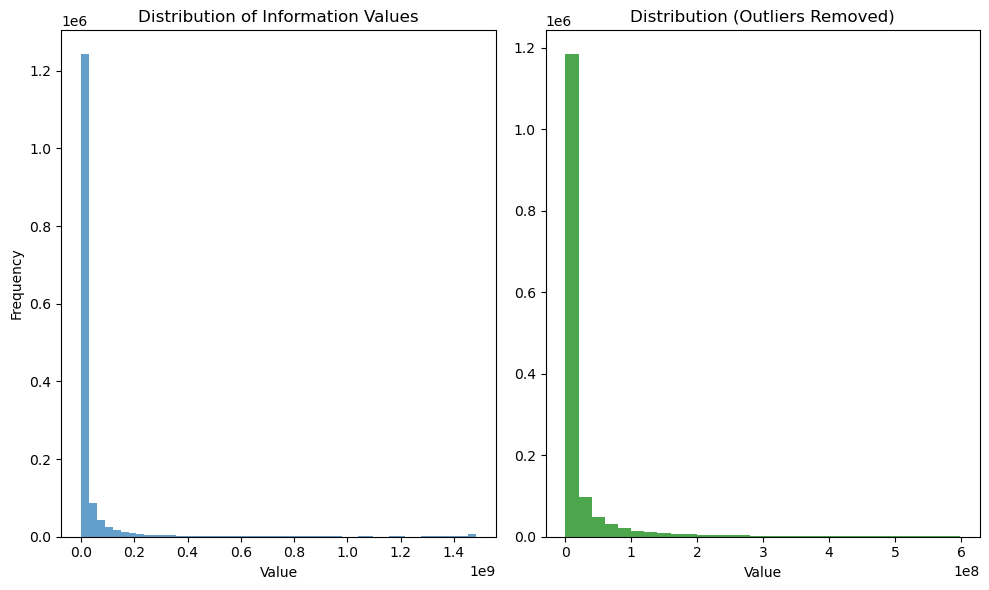

Sum of all information values: 67387533557760.000000
Mean: 44844692.0
Min: 1.7763568394002505e-11
Max: 1483875968.0
Total number of values: 1502687
Sum of all information values: 33261518585856.000000
Mean: 22586428.0
Min: 1.7763568394002505e-11
Max: 598822784.0
Total number of values: 1472633


(67387533557760.0, 33261518585856.0)

In [23]:
plot_information(info_true)

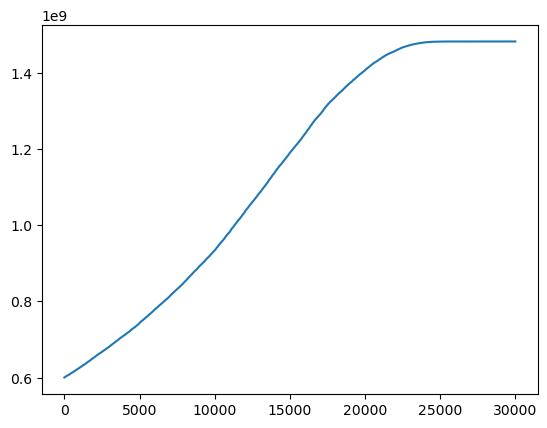

In [24]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))

#Find elbow
# from kneed import KneeLocator
# kl = KneeLocator(range(len(s_infocat)), s_infocat, curve='convex', direction='increasing')
# #kl.plot_knee()
# informative_params = len(s_infocat)-kl.knee
# print(f"Number of informative parameters: {informative_params}")

n=40 # print the last n*informative_params parameters
#plt.plot(s_infocat[-informative_params*n:])
plt.plot(s_infocat[-30000:])
##Plot the knee
#plt.axvline(informative_params*(n-1), color='red', linestyle='--')
plt.show()


Parameters reset unlearning

In [107]:
treshold = s_infocat[-5000]
retrain_param_indices = [torch.argwhere(p >= treshold) for p in info_true]

model_reset = copy.deepcopy(saved_model).cpu()
model_null = FLNet2()

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)


# Compute accuracy for each client
def compute_accuracy(model, testloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

def compute_accuracy_per_client(model, testloader_list):
    accuracies = []
    for i, testloader in enumerate(testloader_list):
        acc = compute_accuracy(model, testloader)
        accuracies.append(acc)
        print(f"Accuracy for client {i}: {acc:.2f}%")

print("Accuracy before resetting:")
compute_accuracy_per_client(saved_model, trainloader_lst)
print("Accuracy after resetting:")
compute_accuracy_per_client(model_reset, trainloader_lst)



Accuracy before resetting:
Accuracy for client 0: 99.51%
Accuracy for client 1: 99.89%
Accuracy for client 2: 99.70%
Accuracy for client 3: 99.34%
Accuracy for client 4: 99.33%
Accuracy after resetting:
Accuracy for client 0: 99.51%
Accuracy for client 1: 99.89%
Accuracy for client 2: 99.70%
Accuracy for client 3: 99.34%
Accuracy for client 4: 99.33%


In [ ]:
class UnlearnNet(nn.Module):
    def __init__(self, model, retrain_param_indices):
        super(UnlearnNet, self).__init__()

        self.container = {"model" : FLNet2()}

        self.retrain_param_indices = [retrain_param_indices[i].cpu() for i in range(len(retrain_param_indices))] 

        self.model_parameters = {}
        for i, (name, p) in enumerate(model.named_parameters()):
            new_p = p.clone().detach()
            new_p[tuple(self.retrain_param_indices[i].t())] = 0
            self.model_parameters[name] = new_p

        for name, param in self.model_parameters.items():
            name_temp = name.replace(".", "_")
            self.register_buffer(f"model_parameter_{name_temp}", param)

        retrain_parameters = {}
        for i, (name, p) in enumerate(model.named_parameters()):
            if len(self.retrain_param_indices[i]) == 0:
                continue
            retrain_parameters[name.replace(".","_")] = torch.randn(len(self.retrain_param_indices[i]))

        self.retrain_parameters = torch.nn.ParameterDict(retrain_parameters)
        
        retrain_param_masks = {}
        for i, (name, p) in enumerate(model.named_parameters()):
            if len(self.retrain_param_indices[i]) == 0:
                continue
            list_indices = self.retrain_param_indices[i].tolist()
            list_tens_indices = [torch.cat([torch.tensor(list_indices[j]),torch.tensor([j])]) for j in range(len(list_indices))]
            tens_indices= torch.stack(list_tens_indices).T.tolist()
            tens_size = torch.Size(torch.cat([torch.tensor(list(p.size())),torch.tensor([len(list_indices)])]))
            name_temp = name.replace(".", "_")
            retrain_param_masks[f"mask_{name_temp}"] = torch.sparse_coo_tensor(tuple(tens_indices), [torch.tensor([1])]*len(list_indices), size=tens_size, dtype=torch.float32)
        
        for name, mask in retrain_param_masks.items():
            self.register_buffer(name, mask)

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        Args:
            sp_tensor (torch.Tensor): A sparse_coo tensor of shape (..., N).
                                    Autograd is not required for this tensor.
            vec       (torch.Tensor): A dense 1D tensor of shape (N,) for which
                                    we want gradients.

        Returns:
            torch.Tensor: A new sparse_coo tensor of shape (...). Its nonzero
                        values depend on 'vec' in a differentiable manner.
        """
        # 1) Ensure sp_tensor is coalesced (merges duplicate indices)
        sp_tensor = sp_tensor.coalesce()

        # 2) Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values  = sp_tensor.values()

        # 3) Multiply each sparse value by the corresponding entry in 'vec'
        #    The last row of indices (indices[-1]) selects which element in vec
        #    to use for each nonzero in the sparse tensor.
        new_values = values * vec[indices[-1]]

        # 4) Create a new sparse_coo_tensor with one fewer dimension:
        #    - drop the last dimension from 'indices'
        #    - the new shape is sp_tensor.shape[:-1]
        out_shape   = sp_tensor.shape[:-1]
        out_indices = indices[:-1, :]

        out_sp = torch.sparse_coo_tensor(
            out_indices,
            new_values,
            size=out_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        # Optionally, coalesce the result so PyTorch merges duplicates
        out_sp = out_sp.coalesce()
        return out_sp


    
    def forward(self, x):
        model = self.container["model"]
        state_dict = self.state_dict()
        params = {}
        for name in self.model_parameters.keys():
            name_temp = name.replace(".", "_")
            params[name] = state_dict[f"model_parameter_{name_temp}"]

        for name in self.retrain_parameters.keys():
            name_mask = f"mask_{name}"
            name_model_parameters = f"model_parameter_{name}"
            name_model = name.replace("_", ".")

            contracted = self.contract_last_dim_with_vector(state_dict[name_mask], self.retrain_parameters[name])

            params[name_model] = state_dict[name_model_parameters] + contracted

        return torch.func.functional_call(model, params, x)
    


unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

print("Unlearn model dict:")
for key in unlearn_model.state_dict().keys():
    print(key)
    print(unlearn_model.state_dict()[key].shape)

print("Unlearn model parameters:")
for name , param in unlearn_model.named_parameters():
    print(name, param.shape)
    #chech requires_grad
    print(param.requires_grad)

print("Accuracy (reset before retrain)")
compute_accuracy_per_client(unlearn_model, trainloader_lst)




Unlearn model dict:
model_parameter_0_weight
torch.Size([32, 1, 5, 5])
model_parameter_0_bias
torch.Size([32])
model_parameter_3_weight
torch.Size([64, 32, 5, 5])
model_parameter_3_bias
torch.Size([64])
model_parameter_7_weight
torch.Size([512, 3136])
model_parameter_7_bias
torch.Size([512])
model_parameter_9_weight
torch.Size([10, 512])
model_parameter_9_bias
torch.Size([10])
mask_3_weight
torch.Size([64, 32, 5, 5, 9])
mask_7_weight
torch.Size([512, 3136, 4991])
mask_9_weight
torch.Size([10, 512, 1])
retrain_parameters.3_weight
torch.Size([9])
retrain_parameters.7_weight
torch.Size([4991])
retrain_parameters.9_weight
torch.Size([1])
Unlearn model parameters:
retrain_parameters.3_weight torch.Size([9])
True
retrain_parameters.7_weight torch.Size([4991])
True
retrain_parameters.9_weight torch.Size([1])
True
Accuracy
Accuracy for client 0: 98.86%
Accuracy for client 1: 99.71%
Accuracy for client 2: 98.68%
Accuracy for client 3: 98.72%
Accuracy for client 4: 99.18%


In [103]:
num_of_repeats = 1
num_fl_rounds = 3

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

In [104]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
num_parties = 4

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in [0,1,2,4]:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    print(f"Gradient is None for {name}")
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

Training party 0
Gradient norm for retrain_parameters.0_bias: 0.0
Gradient norm for retrain_parameters.0_weight: 1.5545265674591064
Gradient norm for retrain_parameters.3_bias: 2.1792632341384888
Gradient norm for retrain_parameters.3_weight: 11.051112294197083
Gradient norm for retrain_parameters.7_bias: 11.894529044628143
Gradient norm for retrain_parameters.7_weight: 41.20831459760666
Gradient norm for retrain_parameters.9_bias: 41.248720698058605
Gradient norm for retrain_parameters.9_weight: 48.876602701842785
Training party 1
Gradient norm for retrain_parameters.0_bias: 0.0
Gradient norm for retrain_parameters.0_weight: 0.0
Gradient norm for retrain_parameters.3_bias: 0.0
Gradient norm for retrain_parameters.3_weight: 0.0
Gradient norm for retrain_parameters.7_bias: 0.0
Gradient norm for retrain_parameters.7_weight: 0.0
Gradient norm for retrain_parameters.9_bias: 0.0
Gradient norm for retrain_parameters.9_weight: 0.0
Training party 2
Gradient norm for retrain_parameters.0_bias: 

In [110]:
print("Accuracy after retrain")
compute_accuracy_per_client(eval_model, trainloader_lst)

Accuracy after retrain
Accuracy for client 0: 64.42%
Accuracy for client 1: 62.60%
Accuracy for client 2: 62.03%
Accuracy for client 3: 62.01%
Accuracy for client 4: 72.96%


## 4. Unlearn the contribution of the target client
<a id='section_4'></a>

In [ ]:
num_updates_in_epoch = None
num_local_epochs_unlearn = 5
lr = 0.01
distance_threshold = 2.2
clip_grad = 5


initial_model = FLNet()
unlearned_model_dict = {}
for fusion_key in fusion_types_unlearn:
    if fusion_key == 'Retrain':
        unlearned_model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

clean_accuracy_unlearn = {}
pois_accuracy_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn[fusion_key] = 0
    pois_accuracy_unlearn[fusion_key] = 0

for fusion_key in fusion_types:
    if fusion_key == 'Retrain':
        continue

    initial_model = FLNet()
    fedavg_model_state_dict = copy.deepcopy(model_dict[fusion_key])
    fedavg_model = copy.deepcopy(initial_model)
    fedavg_model.load_state_dict(fedavg_model_state_dict)

    party_models = copy.deepcopy(party_models_dict[fusion_key])
    party0_model = copy.deepcopy(party_models[0])

    #compute reference model
    #w_ref = N/(N-1)w^T - 1/(N-1)w^{T-1}_i = \sum{i \ne j}w_j^{T-1}
    model_ref_vec = num_parties / (num_parties - 1) * nn.utils.parameters_to_vector(fedavg_model.parameters()) \
                               - 1 / (num_parties - 1) * nn.utils.parameters_to_vector(party0_model.parameters())

    #compute threshold
    model_ref = copy.deepcopy(initial_model)
    nn.utils.vector_to_parameters(model_ref_vec, model_ref.parameters())

    eval_model = copy.deepcopy(model_ref)
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for Reference Model = {unlearn_clean_acc}')
    unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for Reference Model = {unlearn_pois_acc}')

    dist_ref_random_lst = []
    for _ in range(10):
        dist_ref_random_lst.append(Utils.get_distance(model_ref, FLNet()))

    print(f'Mean distance of Reference Model to random: {np.mean(dist_ref_random_lst)}')
    threshold = np.mean(dist_ref_random_lst) / 3
    print(f'Radius for model_ref: {threshold}')
    dist_ref_party = Utils.get_distance(model_ref, party0_model)
    print(f'Distance of Reference Model to party0_model: {dist_ref_party}')


    ###############################################################
    #### Unlearning
    ###############################################################
    model = copy.deepcopy(model_ref)

    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    model.train()
    flag = False
    for epoch in range(num_local_epochs_unlearn):
        print('------------', epoch)
        if flag:
            break
        for batch_id, (x_batch, y_batch) in enumerate(trainloader_lst[party_to_be_erased]):

            opt.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_joint = -loss # negate the loss for gradient ascent
            loss_joint.backward()
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            opt.step()

            with torch.no_grad():
                distance = Utils.get_distance(model, model_ref)
                if distance > threshold:
                    dist_vec = nn.utils.parameters_to_vector(model.parameters()) - nn.utils.parameters_to_vector(model_ref.parameters())
                    dist_vec = dist_vec/torch.norm(dist_vec)*np.sqrt(threshold)
                    proj_vec = nn.utils.parameters_to_vector(model_ref.parameters()) + dist_vec
                    nn.utils.vector_to_parameters(proj_vec, model.parameters())
                    distance = Utils.get_distance(model, model_ref)

            distance_ref_party_0 = Utils.get_distance(model, party0_model)
            print('Distance from the unlearned model to party 0:', distance_ref_party_0.item())

            if distance_ref_party_0 > distance_threshold:
                flag = True
                break

            if num_updates_in_epoch is not None and batch_id >= num_updates_in_epoch:
                break
    ####################################################################

    unlearned_model = copy.deepcopy(model)
    unlearned_model_dict[fusion_types_unlearn[1]] = unlearned_model.state_dict()

    eval_model = FLNet()
    eval_model.load_state_dict(unlearned_model_dict[fusion_types_unlearn[1]])
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for UN-Local Model = {unlearn_clean_acc}')
    clean_accuracy_unlearn[fusion_types_unlearn[1]] =  unlearn_clean_acc
    pois_unlearn_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for UN-Local Model = {pois_unlearn_acc}')
    pois_accuracy_unlearn[fusion_types_unlearn[1]] =  pois_unlearn_acc

RuntimeError: Error(s) in loading state_dict for FLNet:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "retrain_param_4_0", "retrain_param_4_1", "retrain_param_4_2", "retrain_param_4_3", "retrain_param_4_4", "retrain_param_4_5", "retrain_param_4_6", "retrain_param_4_7", "retrain_param_4_8", "retrain_param_4_9", "retrain_param_4_10", "retrain_param_4_11", "retrain_param_4_12", "retrain_param_4_13", "retrain_param_4_14", "retrain_param_4_15", "retrain_param_4_16", "retrain_param_4_17", "retrain_param_4_18", "retrain_param_4_19", "retrain_param_4_20", "retrain_param_4_21", "retrain_param_4_22", "retrain_param_4_23", "retrain_param_4_24", "retrain_param_4_25", "retrain_param_4_26", "retrain_param_4_27", "retrain_param_4_28", "retrain_param_4_29", "retrain_param_4_30", "retrain_param_4_31", "retrain_param_4_32", "retrain_param_4_33", "retrain_param_4_34", "retrain_param_4_35", "retrain_param_4_36", "retrain_param_4_37", "retrain_param_4_38", "retrain_param_4_39", "retrain_param_4_40", "retrain_param_4_41", "retrain_param_4_42", "retrain_param_4_43", "retrain_param_4_44", "retrain_param_4_45", "retrain_param_4_46", "retrain_param_4_47", "retrain_param_4_48", "retrain_param_6_0". 

## 5. Post-Training
<a id='section_5'></a>

In [ ]:
num_fl_after_unlearn_rounds = num_fl_rounds
num_updates_in_epoch = 50
num_local_epochs = 1

clean_accuracy_unlearn_fl_after_unlearn = {}
pois_accuracy_unlearn_fl_after_unlearn = {}
loss_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    pois_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    loss_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)


for round_num in range(num_fl_after_unlearn_rounds):

    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types_unlearn:
        # Reduce num_parties by 1 to remove the erased party
        fusion = FL_round_fusion_selection(num_parties=num_parties - 1, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(unlearned_model_dict[fusion_key])
        model = FLNet()
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(1, num_parties):
            model = copy.deepcopy(model)
            model_update, party_loss = local_training.train(model=model,
                                        trainloader=trainloader_lst[party_id],
                                        criterion=None, opt=None)

            party_models.append(copy.deepcopy(model_update))
            party_losses.append(party_loss)

        loss_unlearn[fusion_key][round_num] = np.mean(party_losses)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)
        unlearned_model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {unlearn_clean_acc}')
        clean_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_clean_acc
        unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {unlearn_pois_acc}')
        pois_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_pois_acc


Compare the performance of the proposed unlearning method with retraining from scratch (baseline)

In [ ]:
import matplotlib.pyplot as plt

fl_rounds = [i for i in range(1, num_fl_rounds + 1)]

plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'ro--', linewidth=2, markersize=12, label='UN-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'gx--', linewidth=2, markersize=12, label='UN-Backdoor Acc')
plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Retrain'], 'm^-', linewidth=2, markersize=12, label='Retrain-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Retrain'], 'c+-', linewidth=2, markersize=12, label='Retrain-Backdoor Acc')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0, 100])
plt.xlim([1, 10])
plt.legend()
plt.show()